# Trabajo Final - Econometría Espacial
## Propuesta de investigación: análisis espacial del discurso de los senadores nacionales durante la sesión extraordinaria en la que se debatía la interrupción voluntaria del embarazo
### Parte 2 del trabajo:
Ubicación de los senadores dentro del espectro político utilizando componentes princiaples a partir de las votaciones pasadas.

In [1]:
# Paquetes:
# estos creo que no se usan 
from IPython.core.display import HTML
import requests
import matplotlib
import seaborn as sns
from dateutil import parser
import pytz
import pylab as pl
# %pip install pyquery
from pyquery import PyQuery as pq
import scipy
from lxml import etree
import os
from os import path
from pprint import pprint
import dateutil

# estos son los que se usan 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import datetime
import json
%matplotlib inline

In [2]:
# Esta línea de código lee los archivos dentro de la carpeta jsons
# Si se quiere aumentar el rango del loop, hay que obtener los json:
# (1) ir a la terminal de Git Bash, setear el directorio en donde esta este archivo:
# cd "C:\Users\lulap\Documents\Maestria\3er Trimestre\Econometria espacial\Homework\Trabajo final\Espectro-politico-senadores"
# (2) Cheqeuar que el archivo scrape-jsons.sh este dentro de la carpeta del directorio:
# ls
# (3) Correr el archivo habiendo cambiando los numeros de la secuencia dentro del archivo:
# bash scrape-jsons.sh

all_motions_json = []
for i in range(1, 2500+1):
    try:
        j = json.load(open('jsons/%s.json' % i))
        all_motions_json.append(j)
    except:
        pass

In [3]:
# Esta línea de código muestra la fecha de la última sesión
j['fecha']

'16/12/2021'

In [3]:
s_votes = []

for m in all_motions_json:
    v = m['votos']
    s = pd.DataFrame(v)
    s['sesion_id'] = m['sesion_id']
    s['datestr'] = m['fecha']
    s = s.set_index(['legislador_id', 'sesion_id'])
    s_votes.append(s)

In [4]:
# Convierto la lista en un panda data frame:
df_votes = pd.concat(s_votes)

# print(type(s_votes))
# print(type(df_votes))

In [7]:
# Valores posibles que toma la variable voto
df_votes['voto'].unique()

array(['AFIRMATIVO', 'AUSENTE', 'NEGATIVO', 'ABSTENCION', 'PRESIDENTE',
       'Movimiento Popular Neuquino', '', 'LEV.VOT.', 'SIN VOTAR',
       'PRESENTE', 'ABST'], dtype=object)

In [24]:
# Eliminamos las filas con votos que no interesan
df_votes = df_votes[df_votes.voto != 'Movimiento Popular Neuquino']
df_votes = df_votes[df_votes.voto != 'PRESIDENTE']
df_votes = df_votes[df_votes.voto != 'LEV.VOT.']
df_votes = df_votes[df_votes.voto != 'PRESENTE']

In [25]:
# Chequeo haber eliminado bien
df_votes['voto'].unique()

array(['AFIRMATIVO', 'AUSENTE', 'NEGATIVO', 'ABSTENCION', '', 'SIN VOTAR',
       'ABST'], dtype=object)

In [26]:
# Este bloque de código asigna a cada valor posible de voto (string) un valor
def vote_to_number(v):
    MAPPING = {
        'AFIRMATIVO': 1, # Yes
        'AUSENTE': 0, # Absent, did not come to the session
        'NEGATIVO': -1, # No
        'ABSTENCION': 0, # person is present, but not vote
        'ABST': 0,
        'SIN VOTAR': 0,
        '': 0,
    }
    return MAPPING.get(v, 0)
    
df_votes['vote-value'] = df_votes['voto'].apply(vote_to_number)

In [27]:
# En la base de datos, la columna de la fecha es un string, con este bloque de códigos lo paso a formato fecha
from datetime import date

df_votes['date'] = df_votes['datestr'].apply(lambda x: date(
        int(x.split('/')[2]), 
        int(x.split('/')[1]), 
        int(x.split('/')[0])
    ))
df_votes['datetime'] = df_votes['date'].apply(lambda d: datetime.datetime(*d.timetuple()[:7]))

In [28]:
# Calculo la cantidad de partidos políticos dentro de la base de datos
s = df_votes['partido'].value_counts()
df_party_counts = pd.DataFrame(df_votes['partido'].value_counts()).reset_index()
df_party_counts.columns = ['party', 'count']

# Exporto la base de datos a un csv
df_party_counts.to_csv('data/party-count.csv')

In [ ]:
# Vemos el data frame
# df_votes

In [29]:
# Analizando la base de datos:
print('Total number of sessions (ambas camaras):', len(df_votes.reset_index()['sesion_id'].value_counts()))
print('Total number of legislators (senadores y diputados):', len(df_votes.reset_index()['legislador_id'].value_counts()))
print('Total de observaciones:', len(df_votes))

Total number of sessions (ambas camaras): 915
Total number of legislators (senadores y diputados): 1040
Total de observaciones: 189358


In [30]:
# Exporto la base de datos a un csv
df_votes.to_csv('data/votes.csv')

In [31]:
df_member_profile = df_votes.reset_index()[['legislador_id', 'agrupacion', 'agrupacion_color', 'camara', 'mail', 'nombre', 'partido']].drop_duplicates()

# Me quedo sólo con las sesiones que se corresponden con la camara de senadores
# df_member_profile['camara'].unique()
mask = df_member_profile['camara'] == 'senadores'
df_member_profile = df_member_profile.loc[mask]
# df_member_profile['camara'].unique()

print(len(df_member_profile))

df_member_profile = df_member_profile.drop_duplicates('legislador_id')
print('La cantidad de senadores dentro de la base de datos es: ', len(df_member_profile))

# Exporto la base de datos a un archivo csv
df_member_profile.to_csv('data/member-profile.csv')

755
La cantidad de senadores dentro de la base de datos es:  489


In [32]:
df_selected_votes = df_votes[
    # Me quedo con las sesiones desde 2014
    (df_votes['date'] >= date(2013, 12, 12))
    &
    # hasta 2020
    (df_votes['date'] <= date(2020, 12, 12))
]

In [33]:
# Me quedo sólo con las sesiones que se corresponden con la camara de senadores
# df_selected_votes['camara'].unique()

mask = df_selected_votes['camara'] == 'senadores'
df_selected_votes = df_selected_votes.loc[mask]
# df_selected_votes['camara'].unique()

In [34]:
print('Después de filtrar por los años y de quedarnos únicamente con las sesiones de la camara de senadores, la base de datos quedó con', len(df_selected_votes), 'observaciones, y con', len(df_selected_votes.reset_index()['legislador_id'].unique()), 'senadores. ')

Después de filtrar por los años y de quedarnos únicamente con las sesiones de la camara de senadores, la base de datos quedó con 29064 observaciones, y con 486 senadores. 


In [35]:
df_votes_brief = df_selected_votes[['voto', 'vote-value', 'date']]

In [36]:
df_votes_brief

,,voto,vote-value,date
legislador_id,sesion_id,,,
446,706,AFIRMATIVO,1,2016-08-10
362,706,AFIRMATIVO,1,2016-08-10
925,706,AFIRMATIVO,1,2016-08-10
947,706,AFIRMATIVO,1,2016-08-10
946,706,AFIRMATIVO,1,2016-08-10
...,...,...,...,...
930,2156,AUSENTE,0,2020-10-02
266,2156,AUSENTE,0,2020-10-02
1323,2156,AUSENTE,0,2020-10-02


In [37]:
df_votes_brief['voto'].value_counts()

AFIRMATIVO    20261
AUSENTE        5602
NEGATIVO       2395
ABSTENCION      575
                144
SIN VOTAR        85
ABST              2
Name: voto, dtype: int64

In [76]:
# La siguiente línea de código me tira error
# df_matrix = df_votes_brief.reset_index().pivot(index='legislador_id', columns='sesion_id', values='vote-value')
# Separo por año y me fijo en que año esta el problema:

# 2014
df_votes_brief_2014 = df_votes_brief[
    (df_votes_brief['date'] >= date(2013, 12, 12))
    &
    (df_votes_brief['date'] <= date(2014, 12, 12))
]

# 2015
df_votes_brief_2015 = df_votes_brief[
    (df_votes_brief['date'] >= date(2014, 12, 12))
    &
    (df_votes_brief['date'] <= date(2015, 12, 12))
]

# 2016
df_votes_brief_2016 = df_votes_brief[
    (df_votes_brief['date'] >= date(2015, 12, 12))
    &
    (df_votes_brief['date'] <= date(2016, 12, 12))
]

# 2017
df_votes_brief_2017 = df_votes_brief[
    (df_votes_brief['date'] >= date(2016, 12, 12))
    &
    (df_votes_brief['date'] <= date(2017, 12, 12))
]

# 2018
df_votes_brief_2018 = df_votes_brief[
    (df_votes_brief['date'] >= date(2017, 12, 12))
    &
    (df_votes_brief['date'] <= date(2018, 12, 12))
]

# 2019
df_votes_brief_2019 = df_votes_brief[
    (df_votes_brief['date'] >= date(2018, 12, 12))
    &
    (df_votes_brief['date'] <= date(2019, 12, 12))
]

# 2020
df_votes_brief_2020 = df_votes_brief[
    (df_votes_brief['date'] >= date(2019, 12, 12))
    &
    (df_votes_brief['date'] <= date(2020, 12, 12))
]

In [84]:
# Las bases de datos de 2014 y 2015 estan vacias
# df_votes_brief_2014

In [90]:
df_matrix_2016 = df_votes_brief_2016.reset_index().pivot(index='legislador_id', columns='sesion_id', values='vote-value')
df_matrix_2017 = df_votes_brief_2017.reset_index().pivot(index='legislador_id', columns='sesion_id', values='vote-value')
# df_matrix_2018 = df_votes_brief_2018.reset_index().pivot(index='legislador_id', columns='sesion_id', values='vote-value')
# El 2018 me tira el siguiente error:
# Index contains duplicate entries, cannot reshape
df_matrix_2019 = df_votes_brief_2019.reset_index().pivot(index='legislador_id', columns='sesion_id', values='vote-value')
df_matrix_2020 = df_votes_brief_2020.reset_index().pivot(index='legislador_id', columns='sesion_id', values='vote-value')

In [38]:
# Como el problema esta en el 2018, lo saco y trabajo con el resto de los años
df_votes_brief_sin2018 = df_votes_brief[
    ( (df_votes_brief['date'] >= date(2013, 12, 12)) & (df_votes_brief['date'] < date(2017, 12, 12)) )
    | (df_votes_brief['date'] > date(2018, 12, 12))
    ]

In [40]:
# Aplicamos el reshape
df_matrix_sin2018 = df_votes_brief_sin2018.reset_index().pivot(index='legislador_id', columns='sesion_id', values='vote-value')

In [41]:
# Cambiamos por missing values por 0
# df_matrix = df_matrix.fillna(0)
df_matrix_sin2018 = df_matrix_sin2018.fillna(0)

# Importante: Aca esta poniendo como 0 tmb en la columna vote-value a aquellos que tenian valores extraños!

In [42]:
# Exportamos la base de datos como un archivo csv
# df_matrix.to_csv('data/matrix-2014-2020.csv')
df_matrix_sin2018.to_csv('data/matrix-2014-2020-sin2018.csv')

In [43]:
# df_matrix.shape
# (29128, 266)
df_matrix_sin2018.shape
# (488, 230)
# (486, 230)

(486, 230)

#### Componentes princiaples

In [44]:
# X = np.matrix(df_matrix.fillna(0).as_matrix()).astype('int8')
# X = np.matrix.astype('int8')
# X = np.matrix
# X = np.matrix(df_matrix.fillna(0).astype('int8'))
X = np.matrix(df_matrix_sin2018.fillna(0).astype('int8'))

In [45]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(X)
# df_pc = pd.DataFrame(X_reduced, index=df_matrix.index, columns=['PC1', 'PC2', 'PC3'])
df_pc = pd.DataFrame(X_reduced, index=df_matrix_sin2018.index, columns=['PC1', 'PC2', 'PC3'])

In [123]:
# El output de componentes principales es una matriz con el index del legislador y el valor de los 3 componentes princiaples
# df_pc

In [46]:
# Autovalores:
pca.explained_variance_

array([10.14631908,  4.56293317,  3.47177808])

In [47]:
# Porcentaje de la variabilidad de los datos por cada uno de los componentes:
# pca.explained_variance_ratio_
print('El primer componente principal explica el', pca.explained_variance_ratio_[0]*100, 'porciento de la variabilidad de los datos, el segundo componente princiapl explica el', pca.explained_variance_ratio_[1]*100, ', y el tercero, el', pca.explained_variance_ratio_[2]*100)

# ¿no debería sumar 1?
# If n_components is not set then all components are stored and the sum of the ratios is equal to 1.0.

El primer componente principal explica el 30.173783552874422 porciento de la variabilidad de los datos, el segundo componente princiapl explica el 13.569547427748413 , y el tercero, el 10.32459943289939


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

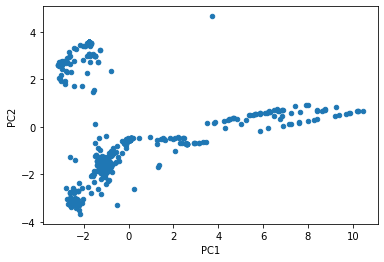

In [48]:
# Gráfico en dos dimensiones
%matplotlib inline
df_pc[['PC1', 'PC2']].plot(x='PC1', y='PC2', kind='scatter')

In [49]:
# Abrimos la base de datos de los partidos políticos para poder diferenciar en el gráfico según el partido político
df_party_count_color = pd.read_csv('data/party-count-color.csv')

In [50]:
print('La cantidad de observaciones (senadores) de la base de datos output de PCA es:', len(df_pc))
print('La cantidad de senadores e info de cada uno es:', len(df_member_profile))

La cantidad de observaciones (senadores) de la base de datos output de PCA es: 486
La cantidad de senadores e info de cada uno es: 489


In [51]:
# Mergeamos ambas bases de datos según el index del legislador
df_pc_member = pd.merge(df_pc.reset_index(), df_member_profile, how='left',
                        left_on='legislador_id', right_on='legislador_id')

In [59]:
# Exportamos la base de datos como un csv
# df_pc_member.to_csv('data/senadores-pca.csv', index=False, encoding = "utf-8")
df_pc_member.to_csv('data/senadores-pca.csv', index=False, encoding = "utf-16")
# df_pc_member.to_csv('data/senadores-pca.csv', index=False, encoding = "utf-8-sig")

In [53]:
print('Ahora entonces hay info y PCA de', len(df_pc_member), 'senadores.')

# Notar que tiene que ser igual len(df_pc) y len(df_pc_member)

Ahora entonces hay info y PCA de 486 senadores.


In [117]:
# plt.scatter(1, 2)
# plt.scatter(2, 3)

('', '')
('Cambiemos', '#FEDB30')
('Consenso Federal / PJ no K', '#00FF50')
('Izquierda', '#D23939')
('Kirchnerismo y aliados', '#A5D4E5')
('Kirchnerismo/PJ', '#A5D4E5')
('Massismo y aliados', '#b185b7')
('Otros', '#A6A6A6')
('PJ ', '#A05F11')
('Peronismo no K', '#00FF50')


Text(0, 0.5, 'PC2')

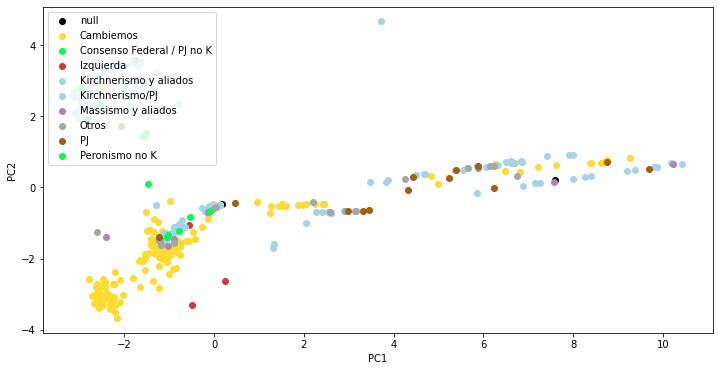

In [54]:
# Gráfico en dos dimensiones pero diferenciando según partido político
plt.figure(figsize=(12, 6))
ax = plt.subplot(1, 1, 1)
from matplotlib.colors import ColorConverter

'''
for (i, m) in df_pc_member.iterrows():
    #print(m['PC1'])
    ax.scatter(m['PC1'], m['PC2'], color=m['_color'])
    #print(m)
'''

for (gname, group) in df_pc_member.groupby(['agrupacion', 'agrupacion_color']):
    print(gname)
    if gname == ('', ''):
        gname = ('null', '#000000')
    ax.scatter(group['PC1'], group['PC2'], color=gname[1], label=gname[0])

plt.legend(loc='upper left')
plt.xlabel('PC1')
plt.ylabel('PC2')

#df_pc[['PC1', 'PC2']].plot(x='PC1', y='PC2', kind='scatter')

('', '')
('Cambiemos', '#FEDB30')
('Consenso Federal / PJ no K', '#00FF50')
('Izquierda', '#D23939')
('Kirchnerismo y aliados', '#A5D4E5')
('Kirchnerismo/PJ', '#A5D4E5')
('Massismo y aliados', '#b185b7')
('Otros', '#A6A6A6')
('PJ ', '#A05F11')
('Peronismo no K', '#00FF50')


Text(0, 0.5, 'PC2')

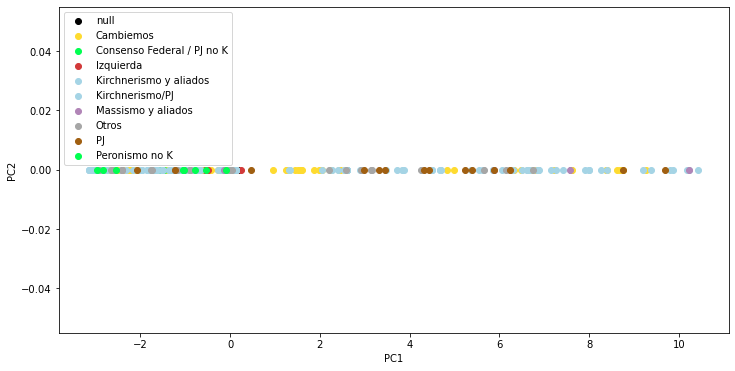

In [55]:
# Gráfico en una única dimensión
%matplotlib inline

plt.figure(figsize=(12, 6))
ax = plt.subplot(1, 1, 1)
from matplotlib.colors import ColorConverter

'''
for (i, m) in df_pc_member.iterrows():
    #print(m['PC1'])
    ax.scatter(m['PC1'], m['PC2'], color=m['_color'])
    #print(m)
'''

for (gname, group) in df_pc_member.groupby(['agrupacion', 'agrupacion_color']):
    print(gname)
    if gname == ('', ''):
        gname = ('null', '#000000')
    ax.scatter(group['PC1'], [0] * len(group['PC1']), color=gname[1], label=gname[0])

plt.legend(loc='upper left')
plt.xlabel('PC1')
plt.ylabel('PC2')

#df_pc[['PC1', 'PC2']].plot(x='PC1', y='PC2', kind='scatter')

In [56]:
df_pc_member['legislador_id'] = df_pc_member['legislador_id'].apply(lambda x: str(x))
open('data/pc-member-3d.json', 'w').write(json.dumps(
    df_pc_member.set_index('legislador_id').T.to_dict()
    ))

130709

('', '')
('Cambiemos', '#FEDB30')
('Consenso Federal / PJ no K', '#00FF50')
('Izquierda', '#D23939')
('Kirchnerismo y aliados', '#A5D4E5')
('Kirchnerismo/PJ', '#A5D4E5')
('Massismo y aliados', '#b185b7')
('Otros', '#A6A6A6')
('PJ ', '#A05F11')
('Peronismo no K', '#00FF50')


8

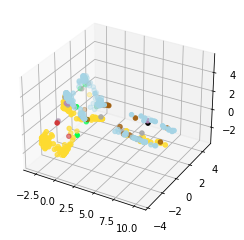

In [57]:
# Gráfico en tres dimensiones:
%matplotlib inline

x = np.array(X_reduced.T[0, :]).astype('float')
y = np.array(X_reduced.T[1, :]).astype('float')
z = np.array(X_reduced.T[2, :]).astype('float')

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for (gname, group) in df_pc_member.groupby(['agrupacion', 'agrupacion_color']):
    print(gname)
    if gname == ('', ''):
        gname = ('null', '#000000')
    ax.scatter(group['PC1'], group['PC2'], group['PC3'], color=gname[1], label=gname[0])
#ax.scatter(x, y, z, picker=True, s=100)

def onpick(X_3D, event):
    #print(event)
    if hasattr(onpick, '_label'):
        #pass
        onpick._label.remove()
    thisline = event.artist
    ind = event.ind
    #print(type(ind))
    #print(X_3D[0, ind])
    # names = df_matrix.iloc[ind].index.values
    names = df_matrix_sin2018.iloc[ind].index.values
    #print(names)
    label = ('\n'.join(names))
    pos = (X_3D[0, ind[0]], X_3D[1, ind[0]], X_3D[2, ind[0]])
    #onpick._label = ax.set_title(label
    onpick._label = ax.text(*pos, s=label)
    fig.canvas.draw()
    
fig.canvas.mpl_connect('pick_event', lambda e: onpick(X_reduced.T, e))